In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw

from py_helper_functions import *

from datetime import datetime

from patsy.highlevel import dmatrices

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

In [2]:
def get_cleaned_data(src: str) -> pd.DataFrame:
    '''
    This function takes a path to a csv file, cleans it and returns the cleaned dataframe
    :param src: path to file
    :return: dataframe with cleaned data
    '''
    df = pd.read_csv(src)
    
    # Filter the data for:
    #
    # new apartment not on market so no need to care about reviews
    working_sample = df[['id','name','host_id','host_name','host_since','host_is_superhost','host_listings_count','host_total_listings_count','host_has_profile_pic','host_identity_verified','neighbourhood_cleansed','property_type','room_type','accommodates','bathrooms_text','bedrooms','beds','amenities','price','minimum_nights','maximum_nights','number_of_reviews','review_scores_value','instant_bookable']
                        ][(df['price'].notna()) 
                        & (df['beds'].notna())
                        & (df['host_is_superhost'].notna())
                        & (df['bathrooms_text'].notna())
                        & (df['room_type'] != 'Hotel room')
                        & (df['accommodates'] <= 6) & (df['accommodates'] >= 2)
                        & (df['neighbourhood_cleansed'].isin(['Palermo', 'Catania', 'Gravina di Catania', 'San Gregorio di Catania', 'Militello in Val di Catania', 'Messina', 'Taormina', 'Realmonte', 'Agrigento', 'Siracusa', 'Cefal', 'Monreale', 'Ragusa', 'Modica']))]
    
    # add boolean variables from text columns
    working_sample['d_host_is_superhost'] = working_sample['host_is_superhost'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_has_profile_pic'] = working_sample['host_has_profile_pic'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_host_identity_verified'] = working_sample['host_identity_verified'].apply(lambda x: 1 if x == 't' else 0)
    working_sample['d_instant_bookable'] = working_sample['instant_bookable'].apply(lambda x: 1 if x == 't' else 0)
    
    # calculate host time
    working_sample['n_host_since'] = working_sample['host_since'].apply(lambda x: (pd.Timestamp('2024-02-02') - pd.Timestamp(x)).days)
    
    # convert price to numerical
    working_sample['price'] = working_sample['price'].apply(lambda x: float(x.replace('$', '').replace(',', '')))
    
    # filter for price < 
    working_sample = working_sample[(working_sample['price'] <= 400)]
    
    # fill NA data for reviews with 0s
    working_sample.fillna(0, inplace=True)
    
    # add numerical variable for number of bath
    working_sample['n_bathrooms'] = working_sample['bathrooms_text'].apply(lambda x: 0.5 if 'half-bath' in x.lower() else float(x.lower().split()[0]))
    
    # clean the property type and room type
    working_sample['property_type'] = working_sample['property_type'].apply(lambda x: x.lower().replace('entire ', '').replace('private room ', '').replace('shared room ', '').replace('room in ', '').replace('in ', ''))
    working_sample['room_type'] = working_sample['room_type'].apply(lambda x: x.lower())
    
    # add amenities columns
    working_sample['d_entertainment'] = working_sample['amenities'].apply(lambda x: 1 if 'tv' in x.lower() or 'game' in x.lower() or 'roku' in x.lower() or 'disney' in x.lower() or 'netflix' in x.lower() or 'nintendo' in x.lower() or'chromecast' in x.lower() or 'alexa' in x.lower() or 'sound' in x.lower() else 0)
    working_sample['d_wifi'] = working_sample['amenities'].apply(lambda x: 1 if 'wifi' in x.lower() else 0)
    working_sample['d_kitchenware'] = working_sample['amenities'].apply(lambda x: 1 if 'fridge' in x.lower() or 'freezer' in x.lower() or 'stove' in x.lower() or 'coffee' in x.lower() or 'oven' in x.lower() or 'blender' in x.lower() or 'grill' in x.lower() or 'dishwasher' in x.lower() else 0)
    working_sample['d_washer'] = working_sample['amenities'].apply(lambda x: 1 if ('washer' in x.lower() or 'dryer' in x.lower() or 'drying' in x.lower()) else 0)
    working_sample['d_sauna_hot_tub'] = working_sample['amenities'].apply(lambda x: 1 if 'sauna' in x.lower() or 'tub' in x.lower() else 0)
    working_sample['d_pool'] = working_sample['amenities'].apply(lambda x: 1 if ' pool' in x.lower() or 'Pool' in x else 0)
    working_sample['d_aircon'] = working_sample['amenities'].apply(lambda x: 1 if 'air con' in x.lower() else 0)
    working_sample['d_heating'] = working_sample['amenities'].apply(lambda x: 1 if 'heating' in x.lower() else 0)
    working_sample['d_scenic_view_access'] = working_sample['amenities'].apply(lambda x: 1 if 'view' in x.lower() or 'access' in x.lower() else 0)
    working_sample['d_parking'] = working_sample['amenities'].apply(lambda x: 1 if 'parking' in x.lower() or 'carport' in x.lower() else 0)
    working_sample['d_pets_allowed'] = working_sample['amenities'].apply(lambda x: 1 if 'pets allowed' in x.lower() else 0)
    working_sample['d_patio_balcony'] = working_sample['amenities'].apply(lambda x: 1 if 'patio' in x.lower() or 'balcony' in x.lower() else 0)
    working_sample['d_bodyshower'] = working_sample['amenities'].apply(lambda x: 1 if 'shampoo' in x.lower() or 'conditioner' in x.lower() or 'soap' in x.lower() or 'gel' in x.lower() else 0)
    
    # rename numerical and categorical columns to have prefix
    working_sample.rename(columns={
        # 'host_listings_count': 'n_host_listings_count',
        # 'host_total_listings_count': 'n_host_total_listings_count',
        'accommodates': 'n_accommodates',
        'bedrooms': 'n_bedrooms',
        'beds': 'n_beds',
        'minimum_nights': 'n_minimum_nights',
        'maximum_nights': 'n_maximum_nights',
        'neighbourhood_cleansed': 'f_neighbourhood_cleansed',
        'property_type': 'f_property_type',
        'room_type': 'f_room_type',
        'review_scores_value': 'n_review_scores_value',
        'number_of_reviews': 'n_number_of_reviews'
    }, inplace=True)
    
    del df
    
    return working_sample

In [3]:
work_df = get_cleaned_data('listings.csv')
# test_df = get_cleaned_data('https://raw.githubusercontent.com/viethngn/Data_Analysis_3_ECBS5171/main/assignment2/listings.csv')
work_df.shape

(16243, 43)

In [4]:
work_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16243 entries, 2 to 51678
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         16243 non-null  int64  
 1   name                       16243 non-null  object 
 2   host_id                    16243 non-null  int64  
 3   host_name                  16243 non-null  object 
 4   host_since                 16243 non-null  object 
 5   host_is_superhost          16243 non-null  object 
 6   host_listings_count        16243 non-null  float64
 7   host_total_listings_count  16243 non-null  float64
 8   host_has_profile_pic       16243 non-null  object 
 9   host_identity_verified     16243 non-null  object 
 10  f_neighbourhood_cleansed   16243 non-null  object 
 11  f_property_type            16243 non-null  object 
 12  f_room_type                16243 non-null  object 
 13  n_accommodates             16243 non-null  int64  


In [5]:
work_df.head()

,id,name,host_id,host_name,host_since,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,...,d_washer,d_sauna_hot_tub,d_pool,d_aircon,d_heating,d_scenic_view_access,d_parking,d_pets_allowed,d_patio_balcony,d_bodyshower
2,22948,B&B NEAR STATION ROOM WITH BALCONY,88837,Giuseppe,2010-03-05,t,4.0,5.0,t,t,...,1,0,0,0,1,1,1,0,1,1
9,200818,Palermo Attic / Holiday House,982293,Nunzia,2011-08-17,f,1.0,1.0,t,f,...,1,0,0,1,0,0,0,0,0,0
11,202166,Holiday House Benedictine Sicily 19087015C206365,843836,Salvo,2011-07-20,f,2.0,2.0,t,t,...,1,0,0,1,1,1,1,0,1,1
12,204652,Al mare in città: Giardino,1006380,Pina Motta,2011-08-22,f,5.0,10.0,t,t,...,1,0,0,0,1,0,0,0,1,1
13,58664,"Holiday Home 100 mt from sea, 4 p.",278397,Pomelia,2010-11-04,t,45.0,52.0,t,t,...,1,0,0,1,1,1,1,1,1,1


In [6]:
work_df.n_review_scores_value.describe(percentiles=[.25, .5, .75, .99])

count    16243.000000
mean         3.460904
std          2.101437
min          0.000000
25%          0.000000
50%          4.680000
75%          4.900000
99%          5.000000
max          5.000000
Name: n_review_scores_value, dtype: float64

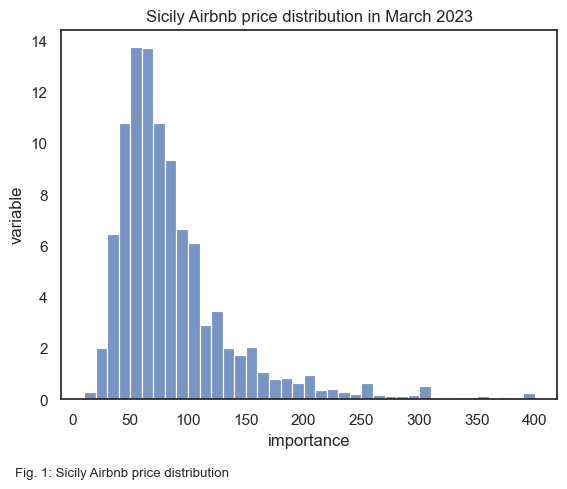

In [7]:
sns.set(style="white")
price_plot, ax3 = plt.subplots()
price_fig = sns.histplot(
    data = work_df,
    x = 'price', stat='percent', binwidth=10)
price_fig.set(title='Sicily Airbnb price distribution in March 2023', xlabel="importance", ylabel="variable")
ax3.text(-50, -3, 'Fig. 1: Sicily Airbnb price distribution', size=9.5)
price_plot.show()

In [8]:
categorical_columns = [col for col in work_df.columns if col.startswith("f_")]
numerical_columns = [col for col in work_df.columns if col.startswith("n_") or col.startswith("d_")]

In [9]:
# build interaction terms
# interactions = ['f_property_type*f_room_type',
#                 'n_accommodates*f_property_type',
#                 'n_accommodates*f_room_type',
#                 'f_property_type*f_neighbourhood_cleansed',
#                 'f_room_type*f_neighbourhood_cleansed',
#                 'n_accommodates*f_neighbourhood_cleansed'
#                 ]
interactions = []
for i in categorical_columns + numerical_columns:
    for k in categorical_columns + numerical_columns:
        if i == k:
            continue
        else:
            interactions.append(i + '*' + k)

In [10]:
# ols get train test split
def get_ols_train_test_split(data, lasso=False):
    if lasso:
        y, ols_df = dmatrices('price~' + '+'.join(numerical_columns) + '+' + '+'.join(categorical_columns) + '+' + '+'.join(interactions), data, return_type="dataframe")
    else:
        y, ols_df = dmatrices('price~' + '+'.join(numerical_columns) + '+' + '+'.join(categorical_columns), data, return_type="dataframe")
    ols_terms_list = ols_df.design_info.column_names
    ols_df['price'] = y
    ols_data_train, ols_data_holdout = train_test_split(ols_df, train_size=0.7, random_state=42)
    return ols_data_train, ols_data_holdout, ols_terms_list

In [11]:
data_train, data_holdout = train_test_split(work_df, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

((11370, 43), (4873, 43))

Simple OLS

In [12]:
ols_data_train, ols_data_holdout, _ = get_ols_train_test_split(work_df)

start_time = datetime.now()
ols_model = LinearRegression().fit(ols_data_train.drop(columns=['price']), ols_data_train['price'])
ols_time = datetime.now() - start_time
ols_model

LinearRegression()

In [13]:
ols_rmse = mean_squared_error(ols_model.predict(ols_data_train.drop(columns=['price'])), ols_data_train['price'], squared=False)
ols_rmse

44.39835625519609

LASSO

In [14]:
# LASSO for OLS
def get_lasso_matrices(data):
    y = data['price']
    X = data.drop(columns=['price'])
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return y, X

In [15]:
%%time
# get lasso data split
lasso_data_train, lasso_data_holdout, lasso_terms_list = get_ols_train_test_split(work_df, lasso=True)

# define model
lasso_model = ElasticNet(l1_ratio = 1, fit_intercept = True)

# define cv search
lasso_search = GridSearchCV(
    lasso_model,
    {"alpha":[i/100 for i in range(5, 60, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

# perform the search
y, X = get_lasso_matrices(lasso_data_train)

start_time = datetime.now()
lasso_results = lasso_search.fit(X, y)
lasso_time = datetime.now() - start_time

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END ......................alpha=0.05;, score=-46.554 total time=  31.2s
[CV 2/5] END ......................alpha=0.05;, score=-43.829 total time=  38.5s
[CV 3/5] END ......................alpha=0.05;, score=-45.206 total time=  25.2s
[CV 4/5] END ......................alpha=0.05;, score=-45.545 total time=  22.0s
[CV 5/5] END ......................alpha=0.05;, score=-45.539 total time=  17.1s
[CV 1/5] END .......................alpha=0.1;, score=-45.866 total time=   8.2s
[CV 2/5] END .......................alpha=0.1;, score=-42.476 total time=   7.6s
[CV 3/5] END .......................alpha=0.1;, score=-44.461 total time=   8.5s
[CV 4/5] END .......................alpha=0.1;, score=-44.807 total time=  10.0s
[CV 5/5] END .......................alpha=0.1;, score=-44.859 total time=  11.7s
[CV 1/5] END ......................alpha=0.15;, score=-45.409 total time=   8.9s
[CV 2/5] END ......................alpha=0.15;, 

In [16]:
lasso_results.best_estimator_

ElasticNet(alpha=0.25, l1_ratio=1)

In [17]:
lasso_results.best_score_

-43.929369640355546

In [18]:
df_lasso_results = pd.DataFrame(lasso_results.cv_results_)[['param_alpha', 'rank_test_score', 'mean_test_score']]
df_lasso_results

,param_alpha,rank_test_score,mean_test_score
0,0.05,11,-45.334646
1,0.1,10,-44.493715
2,0.15,9,-44.142866
3,0.2,4,-43.985576
4,0.25,1,-43.929370
5,0.3,2,-43.938066
6,0.35,3,-43.959676
7,0.4,5,-43.991922
8,0.45,6,-44.030710
9,0.5,7,-44.071708


In [19]:
df_ols_var_coefs = pd.DataFrame(
    lasso_results.best_estimator_.coef_.tolist(),
    index=lasso_terms_list,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]
df_ols_var_coefs['abs_lasso_coefficient'] = df_ols_var_coefs["lasso_coefficient"].apply(lambda x: x if x >= 0 else x * -1)
df_ols_var_coefs.sort_values(by="abs_lasso_coefficient", ascending=False).iloc[:30]

,lasso_coefficient,abs_lasso_coefficient
n_accommodates:n_bedrooms,6.331,6.331
f_room_type[T.private room]:n_bathrooms,-6.140,6.140
d_wifi:d_pool,4.303,4.303
n_bathrooms:d_pool,4.081,4.081
n_accommodates:n_review_scores_value,-4.055,4.055
n_accommodates:n_bathrooms,3.825,3.825
f_property_type[T.bed and breakfast]:d_instant_bookable,3.603,3.603
f_property_type[T.resort]:n_accommodates,3.441,3.441
n_bathrooms:d_wifi,3.074,3.074
n_bedrooms:n_bathrooms,3.005,3.005


Random Forest

In [20]:
# building preprocessing for pipeline
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

In [21]:
tune_grid = {"max_features": [8, 10, 12], "min_samples_leaf": [5, 10, 15]}

rfr = RandomForestRegressor(random_state = 42)

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [22]:
rf_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", rf_random)], verbose=True
)

In [23]:
%%time
start_time = datetime.now()
rf_model = rf_pipe.fit(data_train[numerical_columns + categorical_columns], data_train['price'])
rf_time = datetime.now() - start_time
rf_model

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=8, min_samples_leaf=5;, score=-45.543 total time=   0.5s
[CV 2/5] END max_features=8, min_samples_leaf=5;, score=-42.580 total time=   0.5s
[CV 3/5] END max_features=8, min_samples_leaf=5;, score=-43.440 total time=   0.5s
[CV 4/5] END max_features=8, min_samples_leaf=5;, score=-44.296 total time=   0.5s
[CV 5/5] END max_features=8, min_samples_leaf=5;, score=-45.354 total time=   0.5s
[CV 1/5] END max_features=8, min_samples_leaf=10;, score=-46.238 total time=   0.4s
[CV 2/5] END max_features=8, min_samples_leaf=10;, score=-43.507 total time=   0.4s
[CV 3/5] END max_features=8, min_samples_leaf=10;, score=-44.449 total time=   0.4s
[CV 4/5] END max_features=8, min_samples_leaf=10;, score=-45.222 total time=   0.4s
[CV 5/5] END max_features=8, min_samples_leaf=10;, score=-46.430 total time=   0.4s
[CV 1/5] END max_features=8, min_s

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_neighbourhood_cleansed',
                                                   'f_property_type',
                                                   'f_room_type']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_minimum_nights',
                                                   'n_maximum_nights',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_value',
                                                   'd_host_is_superhost',
                                                   'd_host_has_p...
                                                   'd_sauna_hot_tub', 'd_pool',
                                                   'd_aircon', 'd_heating',
                                                   'd_scenic_view_access',
                                                   'd_parking',
                                                   'd_pets_allowed',
                                                   'd_patio_balcony',
                                                   'd_bodyshower'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=RandomForestRegressor(random_state=42),
                              param_grid={'max_features': [8, 10, 12],
                                          'min_samples_leaf': [5, 10, 15]},
                              scoring='neg_root_mean_squared_error',
                              verbose=3))],
         verbose=True)

In [24]:
df_rf_model_cv_results = pd.DataFrame(rf_random.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
8,44.24,45.17,45.49
10,43.94,44.72,45.16
12,43.71,44.53,44.94


In [25]:
rf_random.best_score_

-43.70544270004076

In [26]:
rf_random.best_estimator_

RandomForestRegressor(max_features=12, min_samples_leaf=5, random_state=42)

Boosting

In [27]:
gbm = GradientBoostingRegressor(learning_rate=0.01, random_state = 42)

tune_grid = {"n_estimators": [200, 300, 500], "max_depth": [5, 10, 15], "min_samples_leaf": [5, 10, 15], "max_features": [6, 8, 10, 12], 'min_samples_split': [10, 20, 30]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [28]:
%%time
start_time = datetime.now()
gbm_model = gbm_pipe.fit(data_train[numerical_columns + categorical_columns],data_train.price)
gbm_time = datetime.now() - start_time
gbm_model

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.0s
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 5/5; 1/324] START max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=200
[CV 5/5; 1/324] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=200;, score=-47.873 total time=   0.7s
[CV 4/5; 2/324] START max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=300
[CV 4/5; 2/324] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=10, n_estimators=300;, score=-45.428 total time=   0.8s
[CV 2/5; 4/324] START max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=200
[CV 2/5; 4/324] END max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=200;, score=-45.076 total time=   0.5s
[CV 5/5; 4/324] START max_depth=5, max_features=6, min_samples_leaf=5, min_samples_split=20, n_estimators=

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_neighbourhood_cleansed',
                                                   'f_property_type',
                                                   'f_room_type']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates',
                                                   'n_bedrooms', 'n_beds',
                                                   'n_minimum_nights',
                                                   'n_maximum_nights',
                                                   'n_number_of_reviews',
                                                   'n_review_scores_value',
                                                   'd_host_is_superhost',
                                                   'd_host_has_p...
                                                   'd_patio_balcony',
                                                   'd_bodyshower'])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(learning_rate=0.01,
                                                                  random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10, 15],
                                          'max_features': [6, 8, 10, 12],
                                          'min_samples_leaf': [5, 10, 15],
                                          'min_samples_split': [10, 20, 30],
                                          'n_estimators': [200, 300, 500]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [29]:
gbm_model_cv.best_score_

-41.29148963763348

In [30]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(learning_rate=0.01, max_depth=15, max_features=10,
                          min_samples_leaf=5, min_samples_split=10,
                          n_estimators=500, random_state=42)

In [31]:
df_gbm_model_cv_results = pd.DataFrame(gbm_model_cv.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'param_max_depth', 'param_n_estimators', 'mean_fit_time', 'mean_test_score']]
df_gbm_model_cv_results.columns = ['max features', 'min node size', 'max depth', '# estimators', 'fit time', 'RMSE']
df_gbm_model_cv_results;

In [32]:
print('OLS RMSE is: {:.4f}.'.format(lasso_results.best_score_*-1))
print('Random Forest RMSE is: {:.4f}.'.format(rf_random.best_score_*-1))
print('GBM RMSE is: {:.4f}.'.format(gbm_model_cv.best_score_*-1))

OLS RMSE is: 43.9294.
Random Forest RMSE is: 43.7054.
GBM RMSE is: 41.2915.


Diagnostic

RF

In [33]:
%%time
rf_result = permutation_importance(
    rf_pipe,
    data_holdout[numerical_columns + categorical_columns],
    data_holdout.price,
    n_repeats=10,
    random_state=42,
    # scoring="neg_root_mean_squared_error"
)
rf_result;

CPU times: user 14.2 s, sys: 306 ms, total: 14.5 s
Wall time: 14.7 s


In [34]:
df_rf_grouped_var_imp = (pd.DataFrame(
        rf_result.importances_mean,
        numerical_columns + categorical_columns)
                      .sort_values(by = 0, ascending = False)
                      .reset_index()
                      .rename(columns={'index': 'variable', 0: 'imp'}))
df_rf_grouped_var_imp['cumulative_imp'] = df_rf_grouped_var_imp.imp.cumsum()
# df_grouped_var_imp.style.format({
#     'imp': lambda x: f'{x:,.1%}',
#     'cumulative_imp': lambda x: f'{x:,.1%}'})
df_rf_grouped_var_imp

,variable,imp,cumulative_imp
0,d_pool,2.901930,2.901930
1,n_bathrooms,2.064651,4.966580
2,f_neighbourhood_cleansed,1.854548,6.821129
3,n_bedrooms,1.553278,8.374407
4,n_number_of_reviews,1.258055,9.632462
5,n_review_scores_value,1.224456,10.856919
6,n_accommodates,1.214572,12.071490
7,f_property_type,0.853047,12.924537
8,n_host_since,0.629531,13.554068
9,f_room_type,0.553215,14.107283


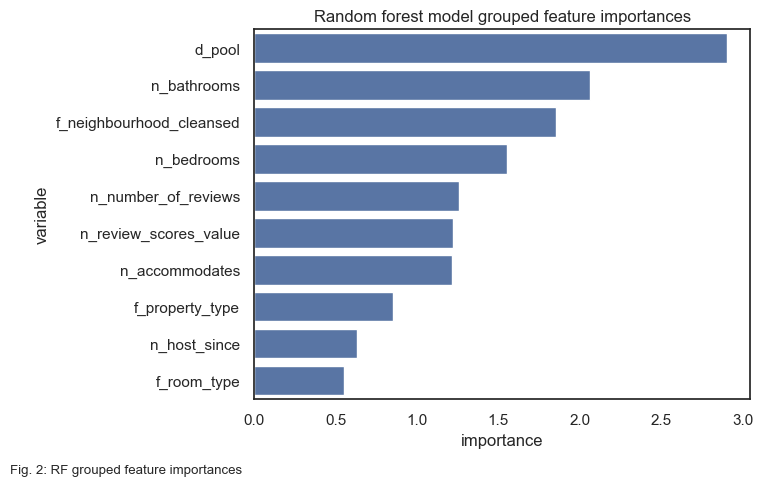

In [35]:
df_rf_grouped_var_imp = df_rf_grouped_var_imp.sort_values(by='imp', ascending=False)

sns.set(style="white")
rf_plot, ax1 = plt.subplots()
rf_fig = sns.barplot(
    data = df_rf_grouped_var_imp.iloc[0:10],
    x="imp", y="variable")
rf_fig.set(title='Random forest model grouped feature importances', xlabel="importance", ylabel="variable")
ax1.text(-1.5, 11.5, 'Fig. 2: RF grouped feature importances', size=9.5)
rf_plot.show()

In [36]:
%%time
gbm_result = permutation_importance(
    gbm_pipe,
    data_holdout[numerical_columns + categorical_columns],
    data_holdout.price,
    n_repeats=10,
    random_state=42,
    # scoring="neg_root_mean_squared_error"
)
gbm_result;

CPU times: user 42.7 s, sys: 346 ms, total: 43 s
Wall time: 42.9 s


In [37]:
df_gbm_grouped_var_imp = (pd.DataFrame(
        gbm_result.importances_mean,
        numerical_columns + categorical_columns)
                      .sort_values(by = 0, ascending = False)
                      .reset_index()
                      .rename(columns={'index': 'variable', 0: 'imp'}))
df_gbm_grouped_var_imp['cumulative_imp'] = df_gbm_grouped_var_imp.imp.cumsum()
# df_grouped_var_imp.style.format({
#     'imp': lambda x: f'{x:,.1%}',
#     'cumulative_imp': lambda x: f'{x:,.1%}'})
df_gbm_grouped_var_imp

,variable,imp,cumulative_imp
0,d_pool,3.654756,3.654756
1,f_neighbourhood_cleansed,2.980392,6.635148
2,n_bathrooms,2.385831,9.020979
3,n_number_of_reviews,1.993006,11.013985
4,n_accommodates,1.593541,12.607526
5,n_host_since,1.524565,14.132091
6,f_property_type,1.491763,15.623853
7,n_bedrooms,1.412760,17.036614
8,n_review_scores_value,1.233258,18.269872
9,f_room_type,0.889089,19.158961


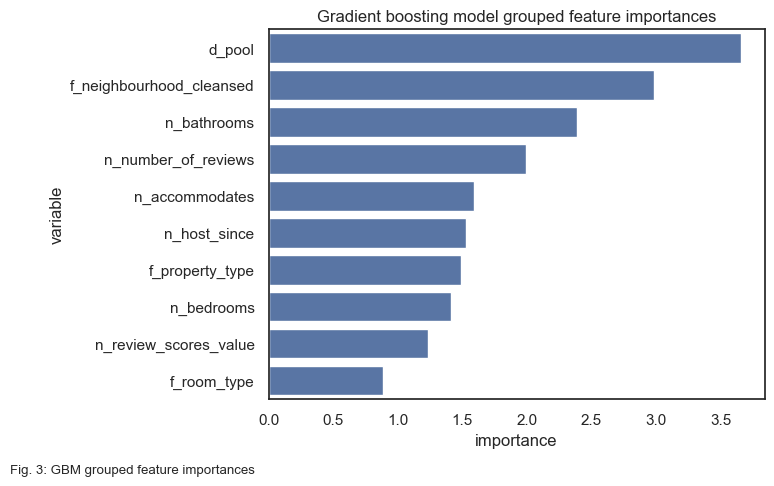

In [38]:
df_gbm_grouped_var_imp = df_gbm_grouped_var_imp.sort_values(by='imp', ascending=False)

sns.set(style="white")
gbm_plot, ax2 = plt.subplots()
gbm_fig = sns.barplot(
    data = df_gbm_grouped_var_imp.iloc[0:10],
    x="imp", y="variable")
gbm_fig.set(title='Gradient boosting model grouped feature importances', xlabel="importance", ylabel="variable")
ax2.text(-2, 11.5, 'Fig. 3: GBM grouped feature importances', size=9.5)
gbm_plot.show()

RMSE training and testing

In [42]:
def get_time_delta(delta):
    return f'{delta.seconds // 60}m{delta.seconds % 60}s'

diagnostic_df = pd.DataFrame({'Model': ['Simple OLS', 'LASSO', 'Random Forest', 'GBM'],
                              'Train RMSE': ['{:.4f}'.format(ols_rmse), '{:.4f}'.format(lasso_search.best_score_*-1), '{:.4f}'.format(rf_random.best_score_*-1), '{:.4f}'.format(gbm_model_cv.best_score_*-1)],
                              'Holdout RMSE': ['{:.4f}'.format(mean_squared_error(ols_model.predict(ols_data_holdout.drop(columns=['price'])), ols_data_holdout['price'], squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(lasso_search.predict(X), y, squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(rf_pipe.predict(data_holdout[numerical_columns + categorical_columns]), data_holdout['price'], squared=False)), 
                                               '{:.4f}'.format(mean_squared_error(gbm_pipe.predict(data_holdout[numerical_columns + categorical_columns]), data_holdout['price'], squared=False))],
                              'Training time': [get_time_delta(ols_time), get_time_delta(lasso_time), get_time_delta(rf_time), get_time_delta(gbm_time)]
                              })
diagnostic_df

,Model,Train RMSE,Holdout RMSE,Training time
0,Simple OLS,44.3984,44.9380,0m0s
1,LASSO,43.9294,44.3935,6m24s
2,Random Forest,43.7054,43.4046,0m23s
3,GBM,41.2915,40.9664,8m42s
